In [1]:
import openforcefield as off
from rdkit import Chem
from rdkit.Chem import AllChem
from simtk import openmm, unit
from simtk.openmm import app
from openforcefield.topology import Topology
from openforcefield.topology import Molecule
from openforcefield.typing.engines.smirnoff import ForceField
from rdkit.Chem.Draw import IPythonConsole

Unable to load toolkit <openforcefield.utils.toolkits.OpenEyeToolkitWrapper object at 0x11ae49be0>.


In [2]:
ff = ForceField('test_forcefields/smirnoff99Frosst.offxml')

In [3]:
def get_energy(system, positions):
    integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
    context = openmm.Context(system, integrator)
    context.setPositions(positions)
    state = context.getState(getEnergy=True)
    energy = state.getPotentialEnergy().in_units_of(unit.kilocalories_per_mole)
    return energy

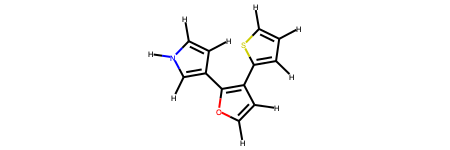

In [4]:
rdmol = Chem.MolFromSmiles('c1c(c2sccc2)c(c3c[nH]cc3)oc1')
rdmol = Chem.AddHs(rdmol)
rdmol

In [5]:
ofmol = Molecule.from_rdkit(rdmol)

In [6]:
ofmol.generate_conformers(n_conformers=10)

In [7]:
topology = ofmol.to_topology()

In [8]:
org_system = ff.create_openmm_system(topology)

In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule '' has more than one conformer, but this function will only generate charges for the first one.


In [9]:
pos = ofmol.conformers[0]

In [10]:
get_energy(org_system, pos)

Quantity(value=80.93719044789302, unit=kilocalorie/mole)

In [11]:
new_system = ff.create_openmm_system(topology)
new_energy = get_energy(new_system, pos)

In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule '' has more than one conformer, but this function will only generate charges for the first one.


In [12]:
from sys import stdout

In [13]:
def minimizeOpenMM(Topology, System, Positions):
    integrator = openmm.LangevinIntegrator(
                                        300.0 * unit.kelvin,
                                        1.0 / unit.picosecond,
                                        2.0 * unit.femtosecond)
                                        #.002 * unit.picoseconds)
    simulation = app.Simulation(Topology, System, integrator)
    simulation.context.setPositions(Positions)
    simulation.minimizeEnergy(tolerance=5.0E-9, maxIterations=2000)
    state =  simulation.context.getState(getPositions=True, getEnergy=True)
    positions =state.getPositions(asNumpy=True)
    energy = state.getPotentialEnergy().in_units_of(unit.kilocalories_per_mole)
    
    #simulation.reporters.append(app.PDBReporter('output.pdb',1000))
    simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, potentialEnergy=True, temperature=True))
    simulation.step(30000)
    print(energy)
    positions = positions / unit.angstroms
    coordlist = list()
    for atom_coords in positions:
        coordlist += [i for i in atom_coords]
    return coordlist, positions

In [14]:
cl, pos=minimizeOpenMM(topology, org_system, pos)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,303.7572021484375,320.95429147377286
2000,267.20831298828125,325.74792246663577
3000,280.2032165527344,283.3522166288418
4000,300.4429626464844,325.73249280731136
5000,282.4346618652344,305.7867865602411
6000,292.1787414550781,255.8760092096109
7000,287.2421569824219,284.1535951107276
8000,315.7651062011719,275.5848516642083
9000,277.49658203125,271.88213251347923
10000,264.98907470703125,351.950709005647
11000,290.98974609375,332.43970207275333
12000,317.70172119140625,331.1092272421846
13000,292.1898498535156,264.8119801610261
14000,290.4225769042969,275.6358551372331
15000,272.679931640625,328.0959683125404
16000,277.7812805175781,349.2769170182702
17000,283.5809020996094,372.79145805979783
18000,301.0356140136719,254.38279644483453
19000,291.8669128417969,204.14689745823287
20000,272.80206298828125,320.580612512673
21000,259.860107421875,273.23898047345443
22000,283.7405090332031,245.24715431534588
23000,275.8916015625,205

In [15]:
from rdkit.Chem import rdGeometry
from rdkit.Chem.rdchem import Conformer

In [16]:
AllChem.EmbedMolecule(rdmol, useExpTorsionAnglePrefs = True , useBasicKnowledge = True)

0

In [17]:
conf = rdmol.GetConformer()

In [19]:
w=Chem.SDWriter("test1.sdf")
w.write(rdmol)
w.close()

In [20]:
for i in range(rdmol.GetNumAtoms()):
    conf.SetAtomPosition(i, rdGeometry.Point3D(pos[i][0], pos[i][1],pos[i][2],))

In [21]:
w=Chem.SDWriter("test2.sdf")
w.write(rdmol)
w.close()

In [22]:
from ipymol import viewer

In [23]:
viewer.start()

In [24]:
viewer.load("test1.sdf")

In [25]:
viewer.load("test2.sdf")

In [26]:
viewer.align("test1","test2")

[1.0926387310028076, 20, 4, 1.7288460731506348, 24, 5.0, 1]

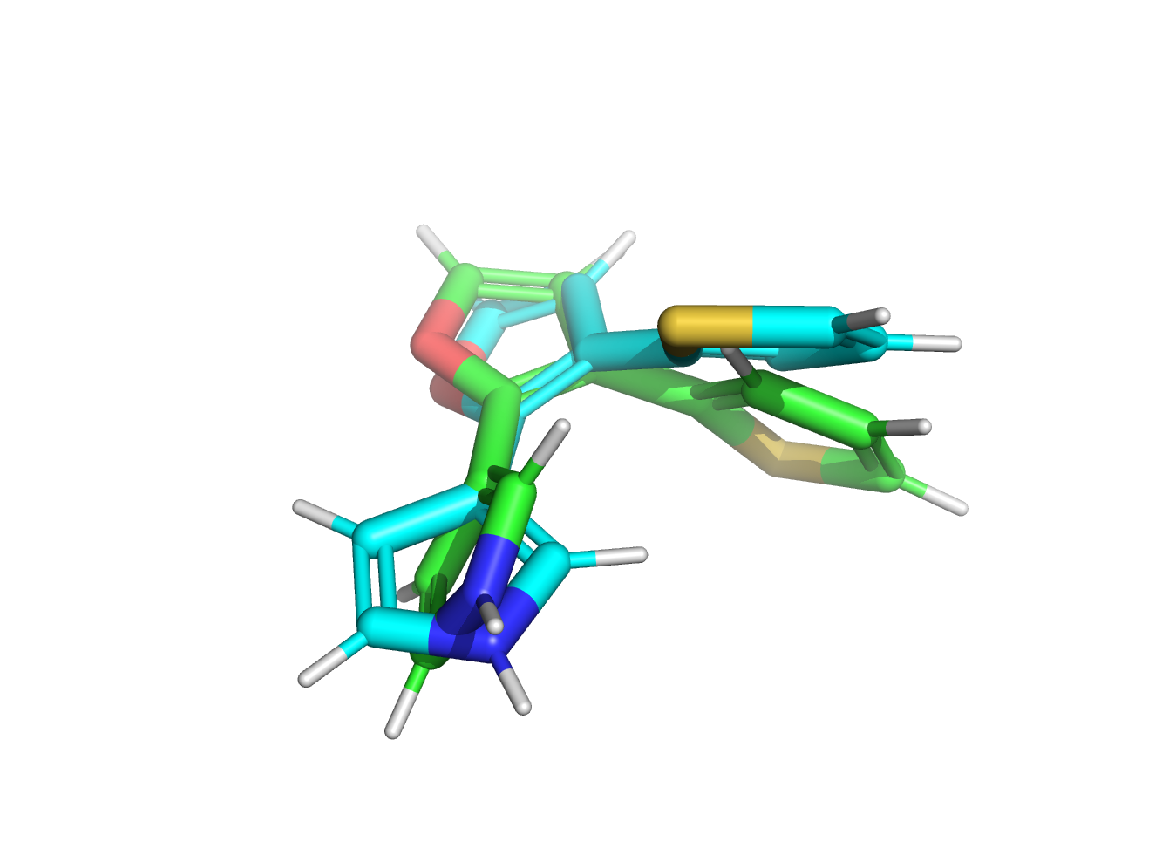

In [27]:
viewer.ray()
viewer.display()

In [28]:
viewer.deleteAll()

''

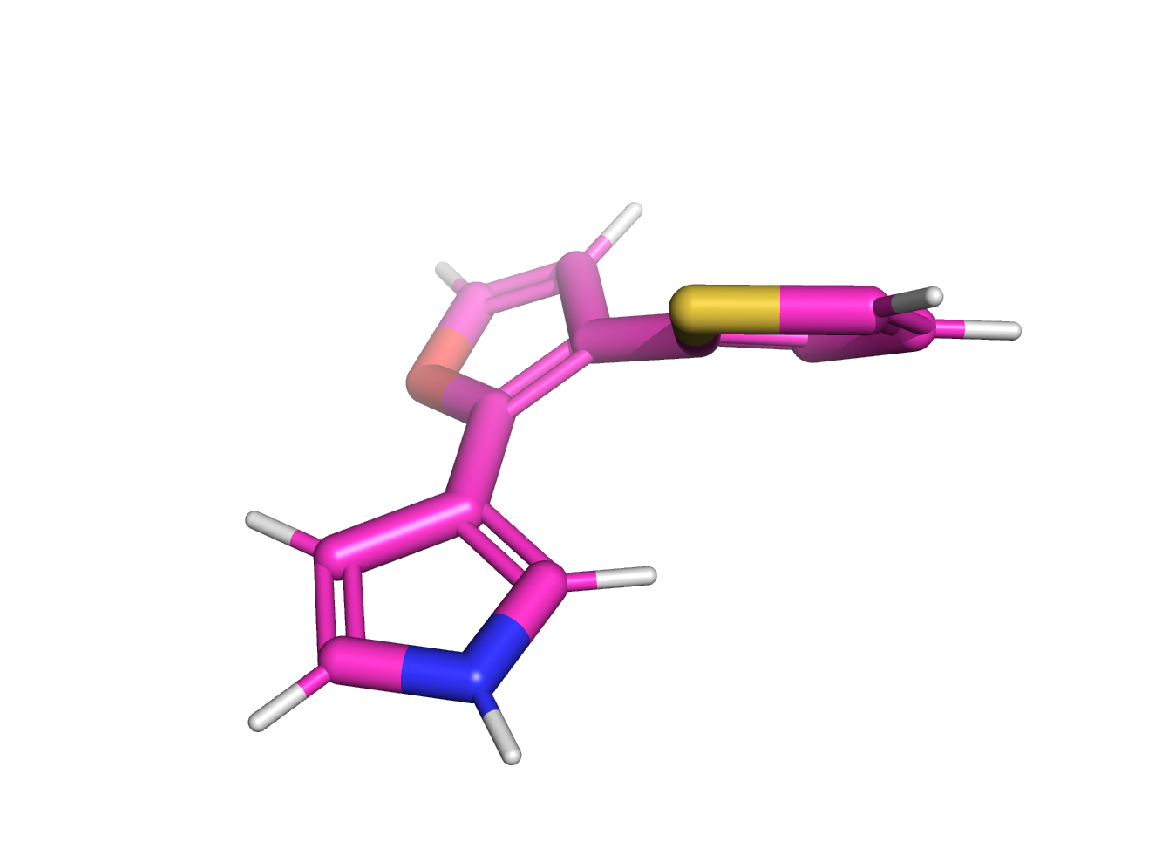

In [29]:
viewer.load("test2.sdf")
viewer.ray()
viewer.display()

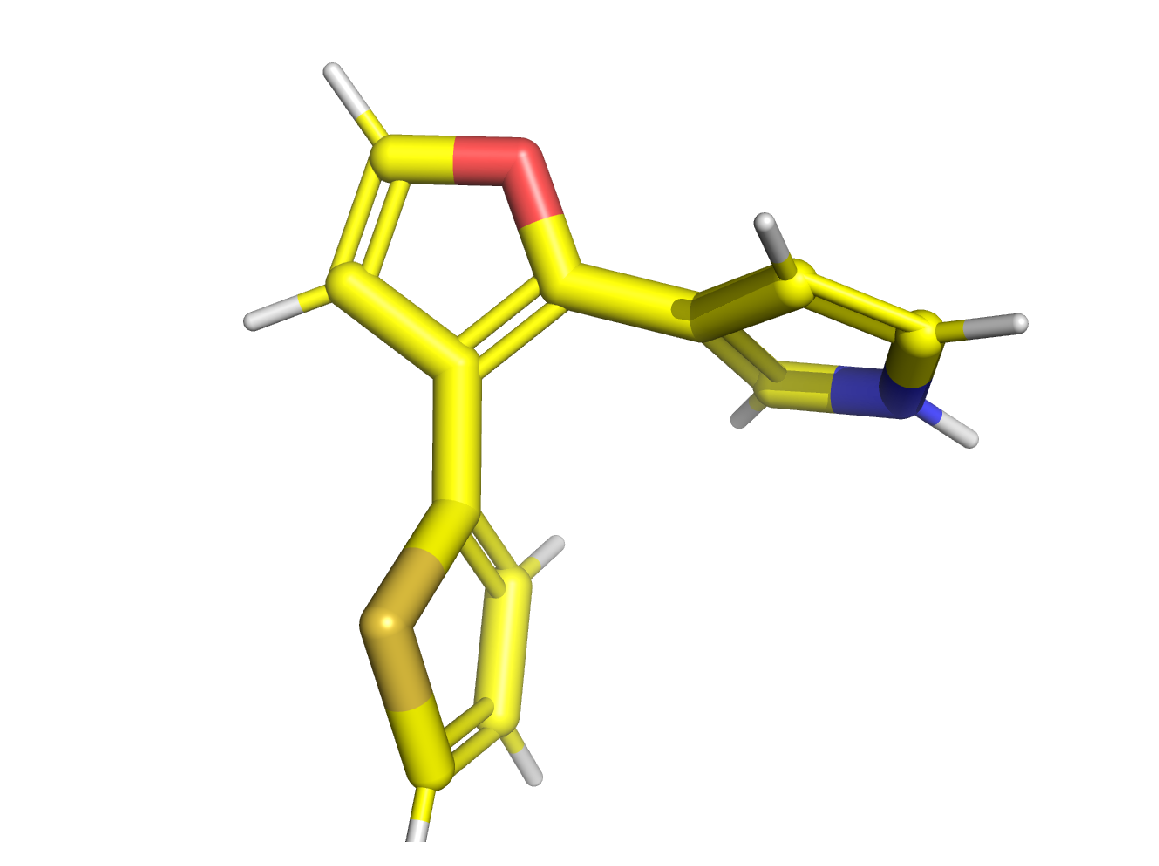

In [30]:
viewer.deleteAll()
viewer.load("test1.sdf")
viewer.ray()
viewer.display()